#Learning With Wasserstein Loss

#Author : MADALI NABIL

#Introduction
It is very difficult to obtain a model that captures image markers to monitor the prognosis of the disease. A typical model is based on a large amount of data, using annotated examples of known markers for automatic detection. Only annotations  and detection for known ones have the disadvantage of this approach. The proposed anoGAN (https://arxiv.org/abs/1703.05921) calculates anomalies based on WGAN by learning how WGAN variability of normal volatility  and mapping from image space to latent space. When applied to new data, the model calculates outliers and outliers. This method was applied to Magnetic resonance imaging   of the brain to confirm that abnormal images.



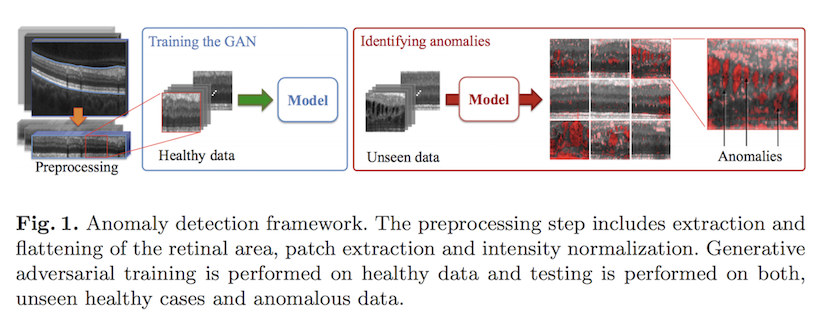

In [1]:
from IPython.display import Image
Image('anoGAN.png')

## Train WGAN with normal image </b>
* Doina Precup and Yee Whye Teh: Wasserstein Generative Adversarial Networks. http://proceedings.mlr.press/v70/arjovsky17a/arjovsky17a.pdf (2017)`







##Mapping new Images to the Latent Space 

* When new data (a query image x) comes in, we aim to find z corresponding to the image G (z) that is most visually similar to the new image x.
To find the best z, we first put a randomly drawn z1 into the trained generator and get G (z1).
* Calculate loss based on G (z1). In this case, loss plays a gradient role to update the coefficient of z1, which means that z1 moves to z2 in latent space. 

* In order to find G (z) most similar to the new data, the position of z in latent space is optimized through iterative calculation through backpropagation. 



### loss 
 The loss used to optimize z consists of two things.
 * residual loss: difference between G (z) and x

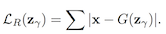

In [2]:
Image('residual.png')

* Discrimination loss: Difference in intermediate layer result of discriminator

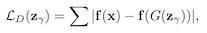

In [3]:
Image('discrimination.png')

f(·) : output of an intermediate layer  of the discriminator 
* overall loss: Weighted sum of residual and discrimination loss 

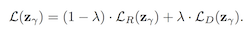

In [4]:
Image('overall.png')

# Anomaly Score

* Use the loss value finally obtained through the mapping process of 2.

* Also, to identify the area of ​​anomaly in the new image, we used the difference image between the most similar image and the new image.





In [5]:
Image('residual_img.png')

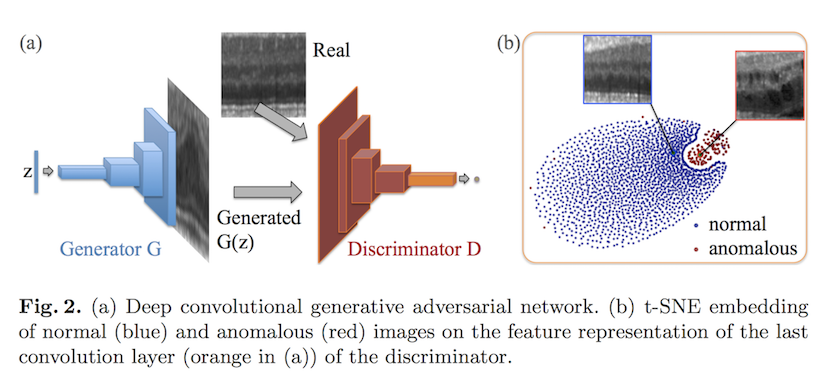

In [6]:
Image('anoGAN2.png')

#2D Patches Extraction

In [0]:
!gdown https://drive.google.com/uc?id=1_XvC98nOaDPzaURewEYF3K0loP4Gkqyl

import zipfile
with zipfile.ZipFile("lgg-mri-segmentation.zip","r") as zip_ref:
    zip_ref.extractall("")

Downloading...
From: https://drive.google.com/uc?id=1_XvC98nOaDPzaURewEYF3K0loP4Gkqyl
To: /content/lgg-mri-segmentation.zip
749MB [00:07, 100MB/s] 


In [0]:
def extract_patches(image, patchshape, overlap_allowed=0.5, cropvalue=None,
                    crop_fraction_allowed=0.1):
    """
    Given an image, extract patches of a given shape with a certain
    amount of allowed overlap between patches, using a heuristic to
    ensure maximum coverage.
    If cropvalue is specified, it is treated as a flag denoting a pixel
    that has been cropped. Patch will be rejected if it has more than
    crop_fraction_allowed * prod(patchshape) pixels equal to cropvalue.
    Likewise, patches will be rejected for having more overlap_allowed
    fraction of their pixels contained in a patch already selected.
    """
    jump_cols = int(patchshape[1] * overlap_allowed)
    jump_rows = int(patchshape[0] * overlap_allowed)
    
    # Restrict ourselves to the rectangle containing non-cropped pixels
    if cropvalue is not None:
        rows, cols = np.where(image != cropvalue)
        rows.sort(); cols.sort()
        active =  image[rows[0]:rows[-1], cols[0]:cols[-1]]
    else:
        active = image

    rowstart = 0; colstart = 0

    # Array tracking where we've already taken patches.
    covered = np.zeros(active.shape, dtype=bool)
    patches = []

    while rowstart < active.shape[0] - patchshape[0]:
        # Record whether or not e've found a patch in this row, 
        # so we know whether to skip ahead.
        got_a_patch_this_row = False
        colstart = 0
        while colstart < active.shape[1] - patchshape[1]:
            # Slice tuple indexing the region of our proposed patch
            region = (slice(rowstart, rowstart + patchshape[0]),
                      slice(colstart, colstart + patchshape[1]))
            
            # The actual pixels in that region.
            patch = active[region]

            # The current mask value for that region.
            cover_p = covered[region]
            if cropvalue is None or \
               frac_eq_to(patch, cropvalue) <= crop_fraction_allowed and \
               frac_eq_to(cover_p, True) <= overlap_allowed:
                # Accept the patch.
                patches.append(patch)
                
                # Mask the area.
                covered[region] = True
                
                # Jump ahead in the x direction.
                colstart += jump_cols
                got_a_patch_this_row = True
                #print "Got a patch at %d, %d" % (rowstart, colstart)
            else:
                # Otherwise, shift window across by one pixel.
                colstart += 1

        if got_a_patch_this_row:
            # Jump ahead in the y direction.
            rowstart += jump_rows
        else:
            # Otherwise, shift the window down by one pixel.
            rowstart += 1

    # Return a 3D array of the patches with the patch index as the first
    # dimension (so that patch pixels stay contiguous in memory, in a 
    # C-ordered array).
    return np.concatenate([pat[np.newaxis, ...] for pat in patches], axis=0)


In [0]:
from sklearn.feature_extraction import image
import cv2
import os
import PIL
import numpy as np
%matplotlib inline
os.mkdir("train_images") 
dics=os.listdir("kaggle_3m")
s=0
for dic in dics:
 if not dic in ["data.csv","README.md"]:
  files=os.listdir("kaggle_3m/"+dic)
  for f in files:
    if not  f.split("_")[-1].split(".")[0] == "mask":
      I = np.asarray(PIL.Image.open('kaggle_3m/'+dic+"/"+f))
      gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
      patches=extract_patches(gray,(28,28))
      for i in range(len(patches)):
        if s <= 50000:
          cv2.imwrite("train_images/patche_"+str(s)+".png", patches[i].reshape(28,28,1))
          s+=1
      

# Import Dependency

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np


Using TensorFlow backend.


In [0]:
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

def gradient_penalty_loss( y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


def wasserstein_loss(y_true, y_pred):
        return K.mean(y_true * y_pred)

In [0]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows,img_cols, channels)
latent_dim = 100

        
n_critic = 5
optimizer = RMSprop(lr=0.00005)


# Generator Model

In [0]:
model = Sequential()
noise = Input(shape=(latent_dim,))
O=Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim)(noise)
O=Reshape((7, 7, 128))(O)
O=UpSampling2D()(O)
O=Conv2D(128, kernel_size=4, padding="same")(O)
O=BatchNormalization(momentum=0.8)(O)
O=Activation("relu")(O)
O=UpSampling2D()(O)
O=Conv2D(64, kernel_size=4, padding="same")(O)
O=BatchNormalization(momentum=0.8)(O)
O=Activation("relu")(O)
O=Conv2D(channels, kernel_size=4, padding="same")(O)
img=Activation("tanh")(O)


generator=Model(inputs=[noise], outputs=[img])

#Discriminator Model

In [0]:
img = Input(shape=img_shape)

O=Conv2D(16, kernel_size=3, strides=2, input_shape=img_shape, padding="same")(img)
O=LeakyReLU(alpha=0.2)(O)
O=Dropout(0.25)(O)
O=Conv2D(32, kernel_size=3, strides=2, padding="same")(O)
O=ZeroPadding2D(padding=((0,1),(0,1)))(O)
O=BatchNormalization(momentum=0.8)(O)
O=LeakyReLU(alpha=0.2)(O)
O=Dropout(0.25)(O)
O=Conv2D(64, kernel_size=3, strides=2, padding="same")(O)
O=BatchNormalization(momentum=0.8)(O)
O=LeakyReLU(alpha=0.2)(O)
O=Dropout(0.25)(O)
O=Conv2D(128, kernel_size=3, strides=1, padding="same")(O)
O=BatchNormalization(momentum=0.8)(O)
O=LeakyReLU(alpha=0.2)(O)
O=Dropout(0.25)(O)
O=Flatten()(O)
validity=Dense(1)(O)


critic = Model(inputs=[img], outputs=[validity])




# WGAN Model

In [0]:
generator.trainable = False
real_img = Input(shape=img_shape)
# Noise input
z_disc = Input(shape=(latent_dim,))

# Generate image based of noise (fake sample)
fake_img = generator(z_disc)

fake = critic(fake_img)
valid = critic(real_img)

# Construct weighted average between real and fake images
interpolated_img = RandomWeightedAverage()([real_img, fake_img])
 # Determine validity of weighted sample
validity_interpolated = critic(interpolated_img)

In [0]:
partial_gp_loss = partial(gradient_penalty_loss,averaged_samples=interpolated_img)
partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

critic_model = Model(inputs=[real_img, z_disc],outputs=[valid, fake, validity_interpolated])
critic_model.compile(loss=[wasserstein_loss,wasserstein_loss,partial_gp_loss],optimizer=optimizer,loss_weights=[1, 1, 10])

# Train The Model

In [0]:
#-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
critic.trainable = False
generator.trainable = True

# Sampled noise for input to generator
z_gen = Input(shape=(latent_dim,))
# Generate images based of noise
img = generator(z_gen)
# Discriminator determines validity
valid = critic(img)
# Defines generator model
generator_model = Model(z_gen, valid)
generator_model.compile(loss=wasserstein_loss, optimizer=optimizer)

In [0]:
def sample_images(epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, latent_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/MRI_Patche_%d.png" % epoch)
        plt.close()

In [0]:
import os
os.mkdir("images")

In [0]:
os.mkdir("weights")

In [0]:

epochs=30000
batch_size=32
sample_interval=100
# Load the dataset

#X_train=np.array([plt.imread(f) for f in os.listdir("train_images")])
        # Rescale -1 to 1

X_train=np.array([np.array(plt.imread("train_images/"+f)*255, dtype=np.uint8) for f in np.array(os.listdir("train_images")) ])
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
# Adversarial ground truths
valid = -np.ones((batch_size, 1))
fake =  np.ones((batch_size, 1))
dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
generator_model_loss=[]
critic_model_loss=[]
for epoch in range(epochs):
            
            for _ in range(n_critic):
               

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, latent_dim))
                # Train the critic
                d_loss = critic_model.train_on_batch([imgs, noise],[valid, fake, dummy])
                critic_model_loss.append(d_loss)

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = generator_model.train_on_batch(noise, valid)
            generator_model_loss.append(g_loss)

            # Plot the progress            
            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
                sample_images(epoch)
critic_model.save_weights('weights/critic_model.h5')
generator_model.save_weights('weights/generator_model.h5')


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: -0.069308] [G loss: -2.095834]
100 [D loss: -0.096044] [G loss: -1.724164]
200 [D loss: -0.148299] [G loss: -2.431037]
300 [D loss: 0.039189] [G loss: -2.926468]
400 [D loss: 0.005371] [G loss: -3.309814]
500 [D loss: -0.031884] [G loss: -2.853822]
600 [D loss: 0.240157] [G loss: -2.497089]
700 [D loss: -0.042188] [G loss: -3.512630]
800 [D loss: -0.018058] [G loss: -2.906058]
900 [D loss: -0.290903] [G loss: -3.621168]
1000 [D loss: -0.585854] [G loss: -3.358594]
1100 [D loss: 0.331024] [G loss: -3.131416]
1200 [D loss: 0.023533] [G loss: -2.203201]
1300 [D loss: -0.187583] [G loss: -2.800493]
1400 [D loss: -0.177166] [G loss: -2.854366]
1500 [D loss: -0.413463] [G loss: -2.355124]
1600 [D loss: -0.221612] [G loss: -2.177713]
1700 [D loss: 0.231566] [G loss: -2.105267]
1800 [D loss: 0.203538] [G loss: -2.681336]
1900 [D loss: -0.154604] [G loss: -2.296006]
2000 [D loss: -0.359286] [G loss: -2.900769]
2100 [D loss: -0.665236] [G loss: -2.429790]
2200 [D loss: -0.157495] [G l

# Anomaly Detection

In [0]:
### generate images
def generate(BATCH_SIZE): 
    noise = np.random.normal(0, 1, (BATCH_SIZE, latent_dim))
    generated_images =generator.predict(noise)
    return generated_images

### anomaly loss function 
def sum_of_residual(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred))

### discriminator intermediate layer feautre extraction
def feature_extractor(d=None):
    
    intermidiate_model = Model(inputs=critic.layers[0].input, outputs=critic.layers[2].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='rmsprop')
    return intermidiate_model

### anomaly detection model define
def anomaly_detector(g=None, d=None):
    
    intermidiate_model = feature_extractor()
    intermidiate_model.trainable = False
    g = Model(inputs=generator.layers[1].input, outputs=generator.layers[-1].output)
    g.trainable = False
    # Input layer cann't be trained. Add new layer as same size & same distribution
    aInput = Input(shape=(100,))
    gInput = Dense((100), trainable=True)(aInput)
    gInput = Activation('sigmoid')(gInput)
    
    # G & D feature
    G_out = g(gInput)
    D_out= intermidiate_model(G_out)    
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights= [0.90, 0.10], optimizer='rmsprop')
    
    # batchnorm learning phase fixed (test) : make non trainable
    K.set_learning_phase(0)
    
    return model

### anomaly detection
def compute_anomaly_score(model, x, iterations=500, d=None):
    z = np.random.normal(0, 1, size=(1, 100))
    
    intermidiate_model = feature_extractor(d)
    d_x = intermidiate_model.predict(x)

    # learning for changing latent
    loss = model.fit(z, [x, d_x], batch_size=1, epochs=iterations, verbose=0)
    similar_data, _ = model.predict(z)
    
    loss = loss.history['loss'][-1]
    
    return loss, similar_data

## combine images for visualization
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:4]
    image = np.zeros((height*shape[0], width*shape[1], shape[2]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1],:] = img[:, :, :]
    return image

<Figure size 720x720 with 0 Axes>

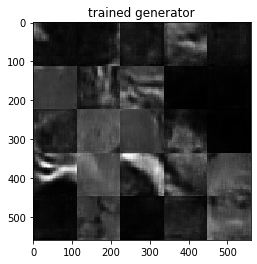

In [0]:
import math
import cv2
generated_img = generate(25)
img = combine_images(generated_img)
img = (img*127.5)+127.5
img = img.astype(np.uint8)
img = cv2.resize(img, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)


plt.figure(figsize=(10,10))
plt.figure(num=0, figsize=(4, 4))
plt.title('trained generator')
plt.imshow(img, cmap=plt.cm.gray)
plt.show()



In [0]:
def anomaly_detection(test_img, g=None, d=None):
    model = anomaly_detector(g=g, d=d)
    ano_score, similar_img =compute_anomaly_score(model, test_img.reshape(1, 28, 28, 1), iterations=500, d=d)

    # anomaly area, 255 normalization
    np_residual = test_img.reshape(28,28,1) - similar_img.reshape(28,28,1)
    np_residual = (np_residual + 2)/4

    np_residual = (255*np_residual).astype(np.uint8)
    original_x = (test_img.reshape(28,28,1)*127.5+127.5).astype(np.uint8)
    similar_x = (similar_img.reshape(28,28,1)*127.5+127.5).astype(np.uint8)

    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)

    return ano_score, original_x, similar_x, show

62.00 8801.59ms
anomaly score :  62.00393295288086


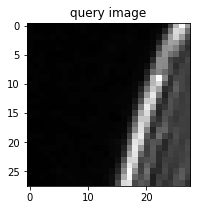

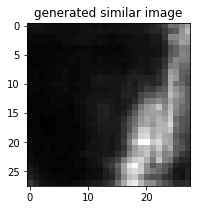

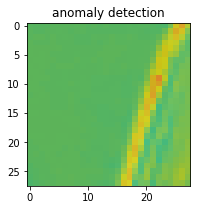

In [0]:
img_idx = np.random.randint(0, X_train.shape[0], 1)
test_img = X_train[img_idx]

start = cv2.getTickCount()
score, qurey, pred, diff = anomaly_detection(test_img)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
print ('%.2f'%score, '%.2fms'%time)

plt.figure(1, figsize=(3, 3))
plt.title('query image')
plt.imshow(qurey.reshape(28,28), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(3, 3))
plt.title('generated similar image')
plt.imshow(pred.reshape(28,28), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()